
Kalibrierung einer Kamera und Messung von Längen von Objekten
und Messung von Distanzen, die ein Objekt zurückgelegt hat in Linux

Plan:
1. Kamera fest montieren, am besten 90° über der zu messenden Ebene
1. Bilder aufnehmen
1. Kamera kalibrieren 
- Kameramatrix (intrinsisch) und Distortion Matrix (extrinsisch) berechnen
- 
1. 




#TODO https://se.mathworks.com/help/vision/ug/evaluating-the-accuracy-of-single-camera-calibration.html 
Quellen:
https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html     
https://learnopencv.com/understanding-lens-distortion/  
https://learnopencv.com/camera-calibration-using-opencv/    
https://pyimagesearch.com/2015/01/19/find-distance-camera-objectmarker-using-python-opencv/     
https://se.mathworks.com/help/vision/ug/camera-calibration.html     
https://pyimagesearch.com/2016/03/28/measuring-size-of-objects-in-an-image-with-opencv/     
https://towardsdatascience.com/what-are-intrinsic-and-extrinsic-camera-parameters-in-computer-vision-7071b72fb8ec   
https://se.mathworks.com/help/vision/ug/evaluating-the-accuracy-of-single-camera-calibration.html   
https://se.mathworks.com/help/vision/ug/measuring-planar-objects-with-a-calibrated-camera.html  


https://de.wikipedia.org/wiki/Brennweite    

Zuerst muss herausgefunden werden, welche Kamera benutzt werden soll. In diesem Beispiel benutzen wir "video3"  
Mit v412-ctl können einige Kameraparameter herausgefunden werden wie z.B. Autofocus. Dieser sollte ausgestellt werden.  

In [9]:
import subprocess

#Bash script that uses v4l2-ctl to find the camera id-thingy. you probably don't have v4l2 installed.
# subprocess.run(args="",executable="./webcam_setup.sh")
subprocess.run("ls /dev | grep video",shell=True)


video0
video1


CompletedProcess(args='ls /dev | grep video', returncode=0)

### Aufnehmen von Bildern
funktioniert leider in Jupyter Notebooks nicht. Die nächste Zelle sollte also einfach in eine Codezelle kopiert werden.

In [10]:
# Source: https://docs.opencv.org/master/dc/dbb/tutorial_py_calibration.html
# '''
# import os
# import shutil
# import numpy as np
# import cv2
# import datetime
# from argparse import ArgumentParser
# from glob import glob
# from os import path

# SPACE_KEY_PRESS = 32
# VIDEO_CAM = 2
# DIRECTORY = "./data/"
# # if os.path.exists(DIRECTORY):
# #     print("moving old chessboards to another folder")
# #     _datetime = datetime.datetime.now()
# #     shutil.move("./data/", "./databefore"+str(_datetime)+"/")
# # os.mkdir(DIRECTORY)
# index = 0
# cv2.namedWindow("Camera Calibration", cv2.WINDOW_NORMAL)
# cam = cv2.VideoCapture(VIDEO_CAM)


# def make_images(visualize=True,index=0):
#     index2=0
#     while True:
#         ret, img_orig = cam.read()
#         assert ret, 'Camera read failed'
#         img = img_orig.copy()
#         img = cv2.putText(img, '<SPACE> to make images, <s> to stop', tuple(
#             x//7 for x in img_orig.shape[:2]), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
#         cv2.imshow('Camera Calibration', img)
#         key = cv2.waitKey(1) & 0xFF
#         if key == ord(" "):
#             index+=1
#             gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
#             if visualize == True:
#                 # Find the chess board corners
#                 ret, corners = cv2.findChessboardCorners(gray, (7, 9), None)
#                 # Draw and display the corners
#                 cv2.drawChessboardCorners(img, (7, 9), corners, ret)
#                 cv2.imshow('img', img)
#                 cv2.waitKey(500)
#             cv2.imwrite("./data/checkerboard_"+str(index)+".png", gray)
#         if key == ord("n"):
#             gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
#             if visualize == True:
#                 # Find the chess board corners
#                 ret, corners = cv2.findChessboardCorners(gray, (7, 9), None)
#                 # Draw and display the corners
#                 cv2.drawChessboardCorners(img, (7, 9), corners, ret)
#                 cv2.imshow('img', img)
#                 cv2.waitKey(500)
#             cv2.imwrite("./data/object_"+str(index2)+".png", gray)
#             index2+=1
#         elif key == ord("s"):
#             break


# make_images(True,index)
# print(index)

### Importieren von Bibliotheken und setzen einiger Konstanten

In [11]:
import matplotlib.pyplot as plt
import cv2
import os
from skimage import color, feature, io, util, measure, filters
from scipy import ndimage as ndi
# TODO shell befehl in python aufrufen und parsen?
# abbruch
# distanzmessung wenn stift sich bewegt

CALIBRESULT = "calibresult.png"
IMG_TO_MEASURE_PATH = "./data/object_1.png"
IMG_TO_MEASURE_PATH_2 = "./data/object_1.png"
SPACE_KEY_PRESS = 32
VIDEO_CAM = 2

### Kalibrierung der Kamera
1. Dieses Python-Skript verwendet OpenCV, um eine Kamera zu kalibrieren, indem es Bilder eines Schachbrettmusters aufnimmt.

1. Es verwendet Fotos von Schachbrettern („checkerboard_scale.png“), um Pixel pro Zentimeter zu berechnen, nachdem es entzerrt wurde.

Kamerakalibrierung:

1. Das Skript findet Ecken in einem Schachbrettmuster in mehreren Bildern.
Anhand dieser Eckpunkte werden Kameramatrizen und Verzerrungskoeffizienten berechnet.
Die Kalibrierung korrigiert Linsenverzerrungen in Bildern.


1. Bilder entzerren:        
Der Code entzerrt ein Beispielbild mithilfe der erhaltenen Kameramatrix und der Verzerrungskoeffizienten.
Das unverzerrte Bild wird als „calibresult.png“ gespeichert.


1. Fehlerberechnung:        
Es berechnet den mittleren Reprojektionsfehler und bewertet die Genauigkeit der Kalibrierung.
Berechnung der durchschnittlichen Entfernung:

1. Es berechnet den durchschnittlichen Abstand in Pixeln zwischen Punkten im Schachbrettmuster.


1. Pixel pro Zentimeter: Es berechnet das Pixel-pro-Zentimeter-Verhältnis basierend auf dem durchschnittlichen Abstand und berücksichtigt dabei, dass auf dem Schachbrett 20 mm pro Quadrat vorhanden sind.
Ausgabe:

1. Der berechnete Pixel-pro-Zentimeter-Wert wird in einer Textdatei mit dem Namen „pixel_per_cm.txt“ gespeichert.
Hinweis: Das Skript geht von einer bestimmten Verzeichnisstruktur und Schachbrettabmessungen aus. Es enthält auch auskommentierten Code zur Anzeige von Zwischenergebnissen.

In [12]:
import os
import numpy as np
import cv2 as cv
import glob
CHECKERBOARD_SCALE="data/checkerboard_scale.png" 
"""
this image is used to calculate pixels per cm after undistorting it.
"""
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((9*7, 3), np.float32)
objp[:, :2] = np.mgrid[0:7, 0:9].T.reshape(-1, 2)
# Arrays to store object points and image points from all the images.


def calculate_matrix_and_undistort(draw_images: bool = True):
    # calculate matrixes
    objpoints = []  # 3d point in real world space
    imgpoints = []  # 2d points in image plane.
    directory = "./data"
    image_paths = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f):
            image_paths.append(f)
    found_imgs, imgs_counter = 0, 0
    for image_path in image_paths:
        img = cv.imread(image_path)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(gray, (7, 9), None)
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            corners2 = cv.cornerSubPix(
                gray, corners, (7, 9), (-1, -1), criteria)
            imgpoints.append(corners2)
            found_imgs += 1
            # Draw and display the corners
            # if (draw_images == True):
            #     cv.drawChessboardCorners(img, (7, 9), corners2, ret)
            #     cv.imshow('img', img)
            #     cv.waitKey(500)

    # display an image to test
    img = cv.imread(CHECKERBOARD_SCALE)
    cv.imwrite("distorted.png", img)
    # x, y = corners2[0][0]
    # x = int(x)
    # y = int(y)
    # x2, y2 = corners2[6][0]
    # x2 = int(x2)
    # y2 = int(y2)
    # if (draw_images == True):
    #     cv.line(img, (x, y), (x2, y2), 4, 3)
    #     cv.imshow("distorted with line", img)
    #     cv.waitKey(5000)
    cv.destroyAllWindows()

    # print the results from the matrix calculation
    print("Checker board detected {}/{}".format(found_imgs, imgs_counter))
    objpoints, imgpoints = np.array(
        objpoints, dtype=np.float32), np.array(imgpoints, dtype=np.float32)
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1], None, None)
    print('Camera Matrix:\n', mtx)
    print('Distortion Matrix', dist)

    # checkerboard 49 is near the centre of the camera.
    # We need a checkerboard near the centre of the camera to measure the pixels per cm accurately.
    # distortion near the edges is very strong and even after undistorting distances scale differently there.
    img = cv.imread(CHECKERBOARD_SCALE)
    h,  w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(
        mtx, dist, (w, h), 1, (w, h))

    # undistort
    undistorted_img = cv.undistort(img, mtx, dist, None, newcameramtx)

    # crop the image
    x, y, w, h = roi
    undistorted_img = undistorted_img[y:y+h, x:x+w]
    cv.imwrite('calibresult.png', undistorted_img)

    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv.projectPoints(
            objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
        mean_error += error
    print("total error: {}".format(mean_error/len(objpoints)))

    objpoints = []  # 3d point in real world space
    imgpoints = []  # 2d points in image plane.
    undistorted_img = undistorted_img
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7, 9), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray, corners, (7, 9), (-1, -1), criteria)
        imgpoints.append(corners2)
        found_imgs += 1
        # Draw and display the corners
        cv.drawChessboardCorners(undistorted_img, (7, 9), corners2, ret)
        if (draw_images == True):
            cv.imshow('undistorted_img', undistorted_img)
            cv.waitKey(5000)
        cv.imwrite("undistorted.png", undistorted_img)
    return corners2, mtx, dist, newcameramtx


corners, mtx, dist, newcameramtx = calculate_matrix_and_undistort(False)
corners = corners[:, 0, :]
print("len=", len(corners))
print("shape=", corners.shape)


def average_distance_20mm_checkerboard(corners):
    """ calculates the average distance measured in pixels between points
    """
    columns = 9
    rows = 7
    diffs = []
    for column in range(columns):
        for row in range(rows):
            index = column*7+row
            # print(corners[index])
            if not row+1 == rows:
                abs = np.abs(corners[index]-corners[index+1])
                diff = pow(np.sum(pow(abs, 2)), 0.5)
                diffs.append(diff)
                print("diff=", diff)
            else:  # if the next item is on a different column
                pass  # skip this distance measurement
    return np.mean(diffs)


pixel_per_cm = average_distance_20mm_checkerboard(corners)/2
print("pixel per cm=", pixel_per_cm)  # /2 because there are 20 mm per square
with open("pixel_per_cm.txt", "w+") as file:
    file.write(str(pixel_per_cm))

Checker board detected 55/0
Camera Matrix:
 [[423.79312526   0.         344.06697127]
 [  0.         423.91252521 240.80561175]
 [  0.           0.           1.        ]]
Distortion Matrix [[-0.156603    0.01606838 -0.00311906 -0.00126999  0.00982891]]
total error: 0.023274792764595865
len= 63
shape= (63, 2)
diff= 15.069694858390465
diff= 15.182072678344905
diff= 15.37346461623536
diff= 15.374494838944608
diff= 15.582392591072294
diff= 15.838558151435574
diff= 15.053540109363603
diff= 15.108152985096945
diff= 15.512252394969416
diff= 15.387147152261576
diff= 15.801096547379533
diff= 15.579840011852557
diff= 15.122398972504122
diff= 15.412246372830793
diff= 15.440569244327333
diff= 15.4389469843113
diff= 15.754234592412715
diff= 15.753260683679704
diff= 15.16714935093585
diff= 15.352323851985732
diff= 15.35456693723656
diff= 15.710189642195603
diff= 15.862836367961398
diff= 15.782389926342251
diff= 15.424901354209997
diff= 15.33518428964144
diff= 15.31356023115216
diff= 15.7866723744493

Edge Detection with Canny

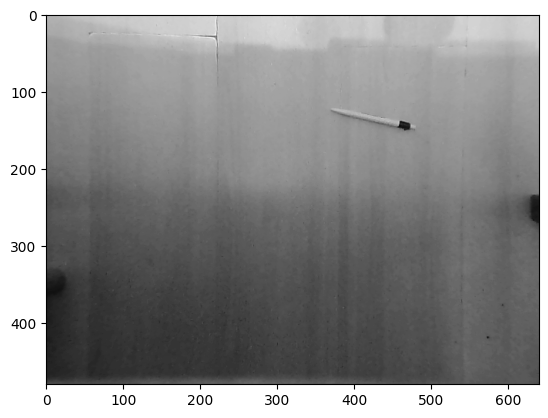

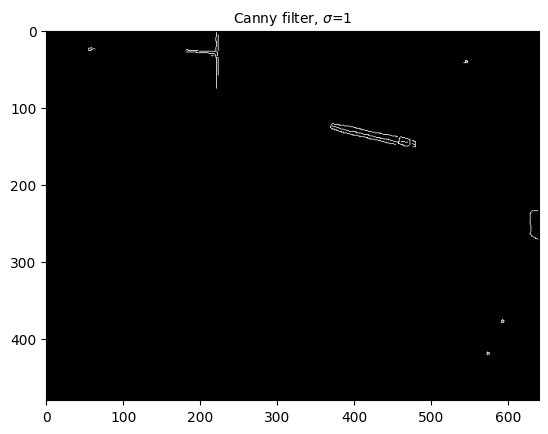

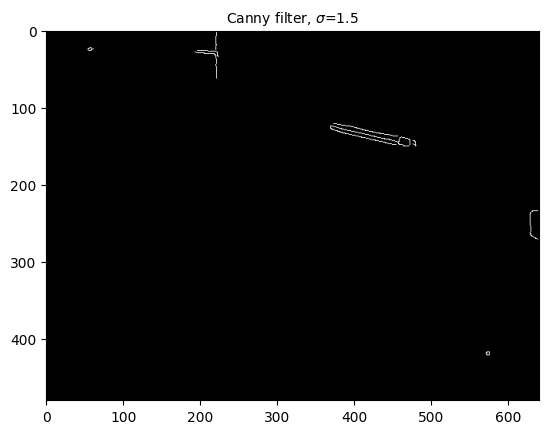

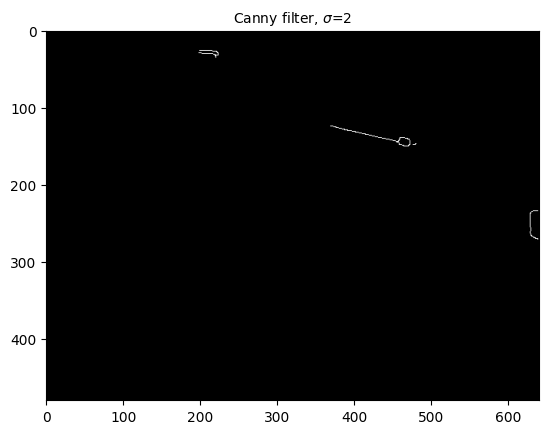

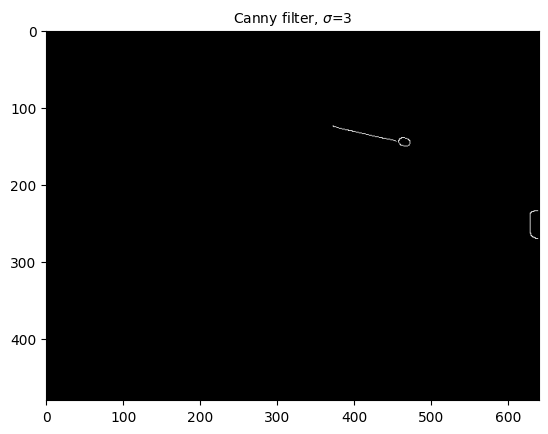

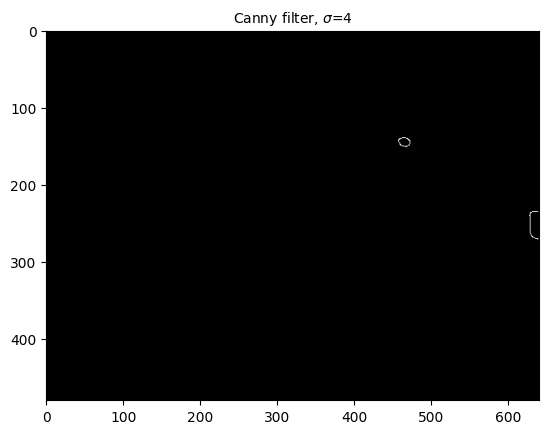

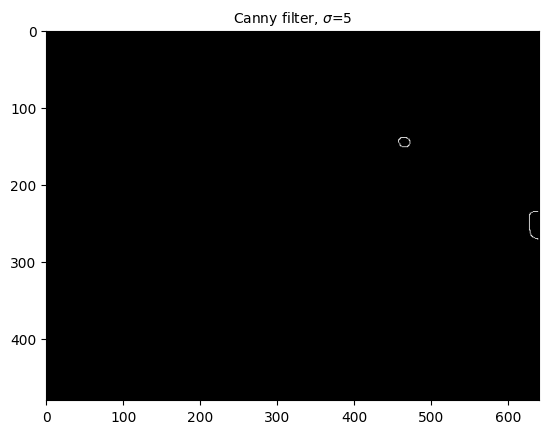

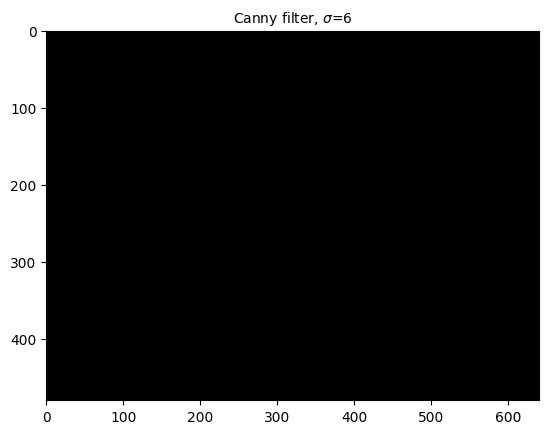

In [13]:
image = io.imread(IMG_TO_MEASURE_PATH)
image = cv.undistort(image, newcameramtx, dist, None, newcameramtx)

def canny_edges(image=image, display=False):
    plt.set_cmap("gray")
    plt.imshow(image)
    plt.show()
    # Compute the Canny filter for some values of sigma
    edges_list = []
    sigmas = [1, 1.5, 2, 3, 4, 5, 6]
    for sigma in sigmas:
        edges_list.append(feature.canny(image, sigma=sigma))

    if (display):
        # display results
        plt.imshow(image, cmap='gray')
        plt.title('noisy image', fontsize=20)

        for i in range(0, len(sigmas)):
            plt.imshow(edges_list[i], cmap='gray')
            plt.title(r'Canny filter, $\sigma$'+"="+str(sigmas[i]), fontsize=10)
            plt.show()
    return edges_list


edges_list = canny_edges(image=image, display=True)

### Finding the pen in the image and measuring it's size
The pen is 13.7 cm, but it is measured as 15.4 cm. I assume there is a bug somewhere in the code.
In the future:
We should measure the checkerboardpattern directly after getting the pixel per cm from it to test.

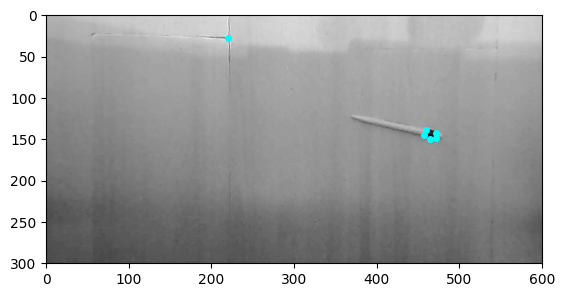

In [14]:
import skimage
from skimage import io, color, morphology, transform, data, draw, feature
from skimage.feature import *
import matplotlib.pyplot as plt


image = io.imread(IMG_TO_MEASURE_PATH)
image = cv.undistort(image, newcameramtx, dist, None, newcameramtx)
# something: np.ndarray = corner_harris(image, k=0.01, eps=0, sigma=1)
# plt.title("something")
# plt.imshow(something)
# plt.show()
coords = corner_peaks(corner_harris(image), min_distance=3, threshold_rel=0.01)
coords_subpix = corner_subpix(image, coords, window_size=10)

fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o', linestyle='None', markersize=4)
# plt.show()
# ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
ax.axis((0, 600, 300, 0))
plt.show()

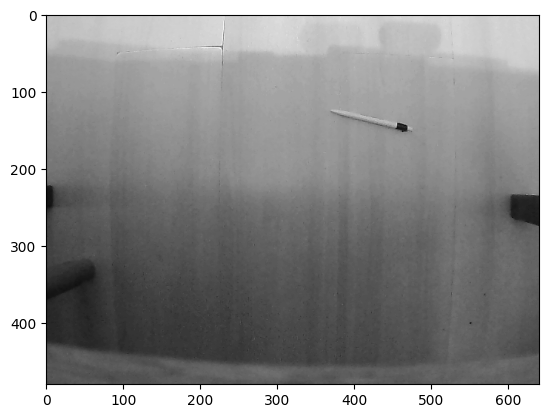

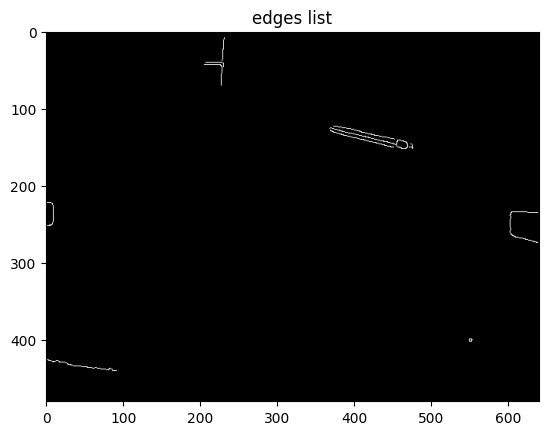

shape= (480, 640)
(307200,)
[[0.001 0.001 0.001]
 [0.001 0.001 0.001]
 [0.001 0.001 0.001]]
(480, 640)
640


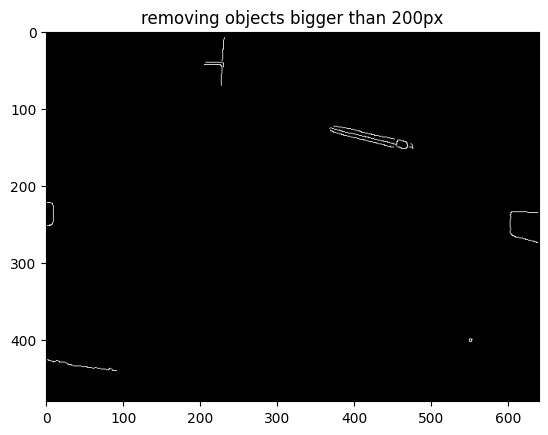

(13, 11)
closing operation repeated times: 5


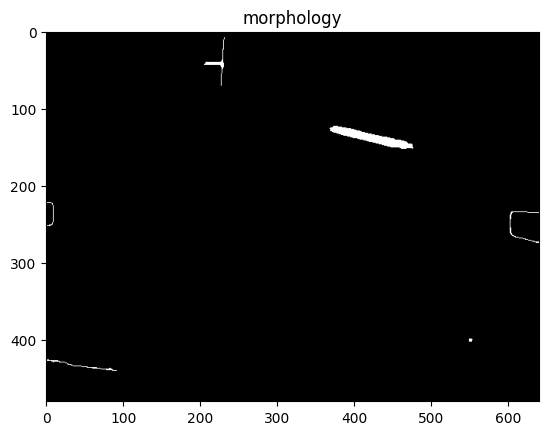

6


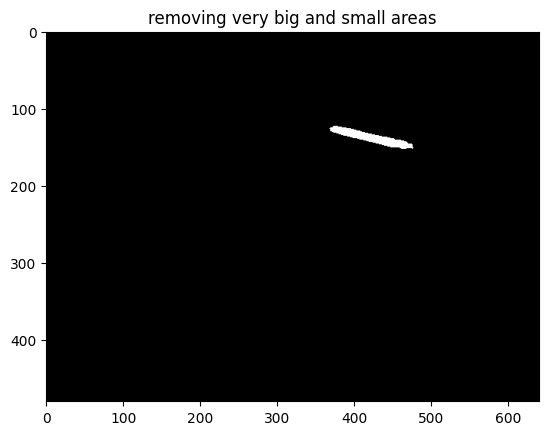

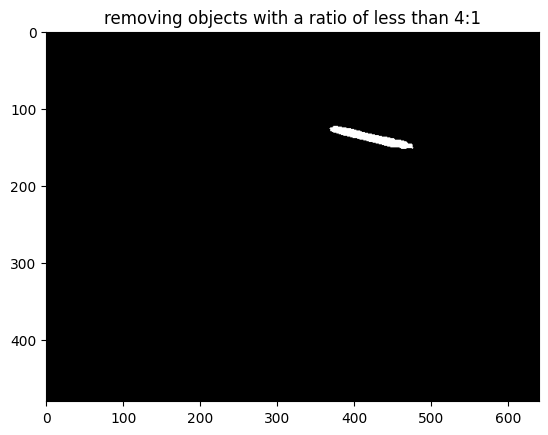

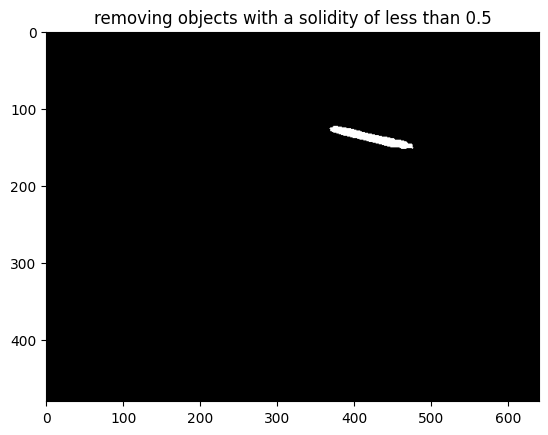

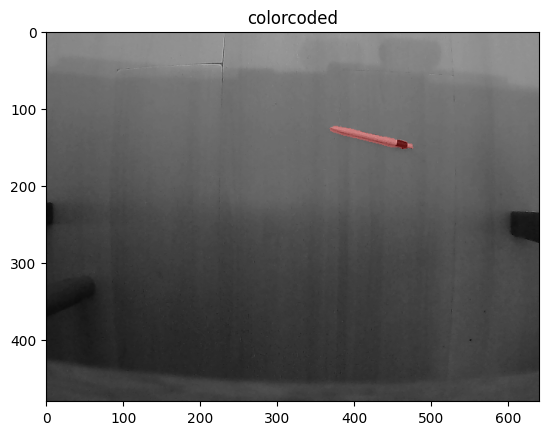

pixel_per_cm= 7.775663474804709
Länge= 15.418274129063558
centroid_location= (138.01087941976428, 421.96464188576607)


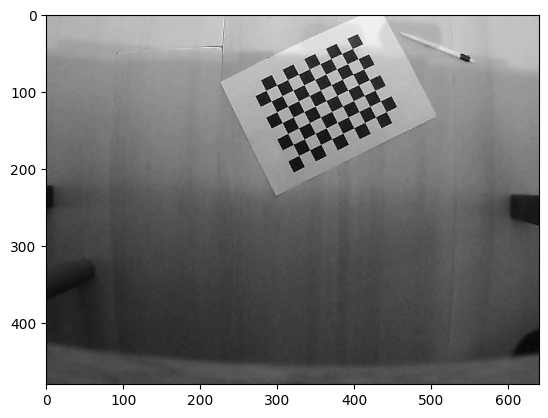

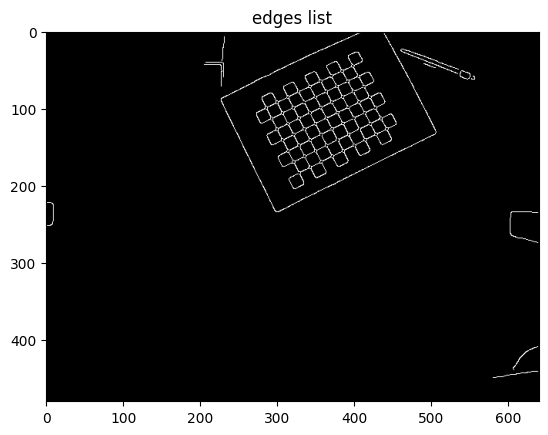

shape= (480, 640)
(307200,)
[[0.001 0.001 0.001]
 [0.001 0.001 0.001]
 [0.001 0.001 0.001]]
(480, 640)
640


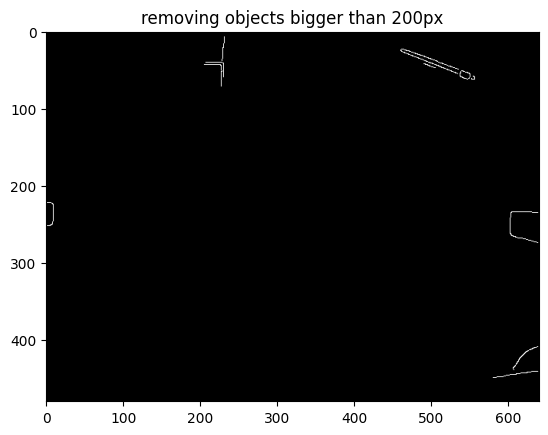

(13, 11)
closing operation repeated times: 5


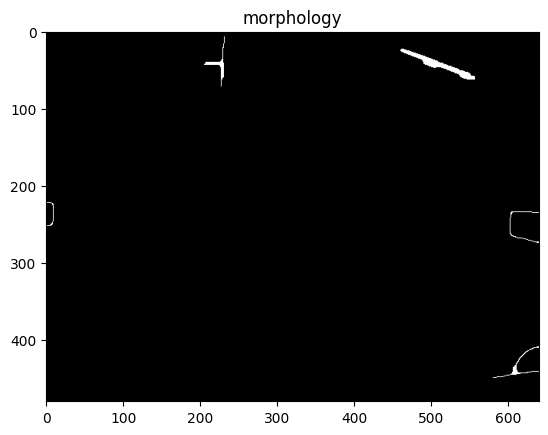

5


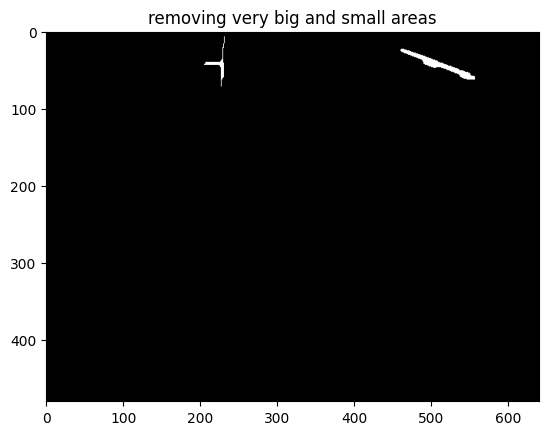

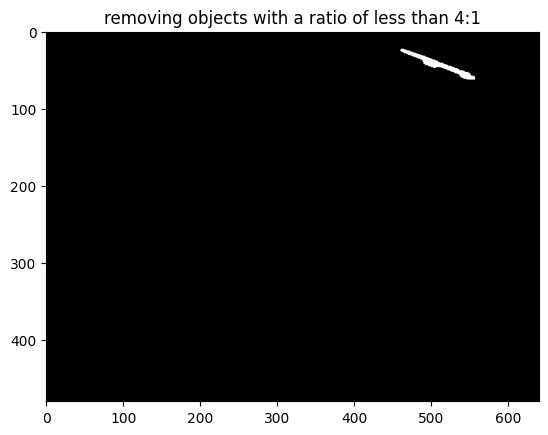

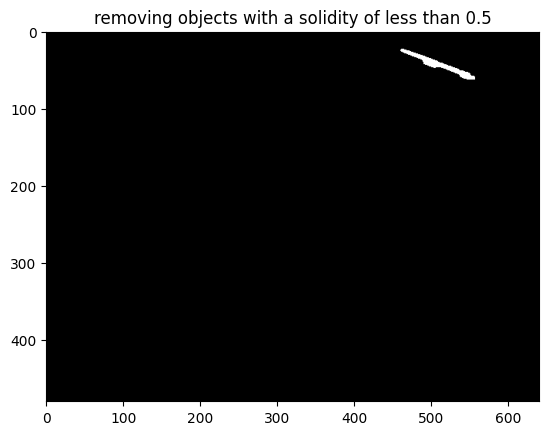

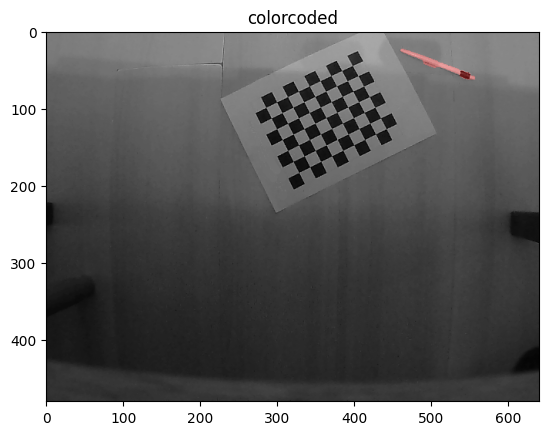

pixel_per_cm= 7.775663474804709
Länge= 14.363782026505316
centroid_location= (43.48450704225352, 510.22816901408453)
centroids= [[(138.01087941976428, 421.96464188576607)], [(43.48450704225352, 510.22816901408453)]]


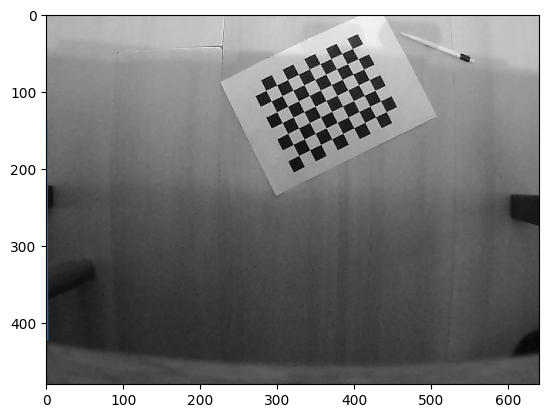

movement= 129.32782104397816 px


In [55]:
from skimage.measure._regionprops import RegionProperties
# IMG_TO_MEASURE_PATH
IMG_TO_MEASURE_PATH2 = "./data/"

def list_full_paths(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory)]


def measure_size_of_obj(image):

    edges_list = canny_edges(image, False)


    img: np.ndarray = edges_list[1]
    plt.imshow(img)
    plt.title("edges list")
    plt.show()


    shape = img.shape
    print("shape=", shape)
    img = img.reshape(shape[0]*shape[1])
    plt.set_cmap("gray")
    print(img.shape)
    img = [1 if x != False else 0.001 for x in img]
    img = np.array(img)
    img = img.reshape(shape)
    print(img[:3, :3])
    # img = 1-img
    print(img.shape)
    label = measure.label(img)
    print(len(label[0]))
    img_colorcoded = color.label2rgb(label, img)
    # plt.imshow(img_colorcoded)
    # plt.colorbar()
    # plt.show()

    #removing big regions
    label = measure.label(img)
    regions = measure.regionprops(label)
    img = np.zeros(img.shape)
    for region in regions:
        region: measure._regionprops.RegionProperties = region
        if region.area < 200:
            coords = region.coords
            for y, z in coords:
                img[y, z] = 1
    plt.imshow(img)
    plt.title("removing objects bigger than 200px")
    plt.show()

    # closing
    ellipse_radius = 5
    # img = edges_list[1]
    fp_ellipse = morphology.ellipse(ellipse_radius, ellipse_radius+1, dtype="bool")
    print(fp_ellipse.shape)
    for i in range(6):
        img = morphology.closing(img, fp_ellipse)
    print("closing operation repeated times:", i)
    # img = morphology.dilation(img)
    plt.imshow(img)
    plt.title("morphology")
    plt.show()

    # a region analysis
    label = measure.label(img)
    regions = measure.regionprops(label)
    print(len(regions))
    img = np.zeros(img.shape)
    x = 0
    for region in regions:
        if region.area < 9000 and region.area > 200:
            x += 1
            coords = region.coords
            for y, z in coords:
                img[y, z] = 1
    plt.imshow(img)
    plt.title("removing very big and small areas")
    plt.show()

    label = measure.label(img)
    regions = measure.regionprops(label)
    img = np.zeros(img.shape)
    for region in regions:
        region: measure._regionprops.RegionProperties = region
        if region.axis_major_length/region.axis_minor_length > 4:
            x += 1
            coords = region.coords
            for y, z in coords:
                img[y, z] = 1
    plt.imshow(img)
    plt.title("removing objects with a ratio of less than 4:1")
    plt.show()

    label = measure.label(img)
    regions = measure.regionprops(label)
    img = np.zeros(img.shape)
    for region in regions:
        region: RegionProperties = region
        if region.solidity > 0.4:
            x += 1
            coords = region.coords
            for y, z in coords:
                img[y, z] = 1
    plt.imshow(img)
    plt.title("removing objects with a solidity of less than 0.5")
    plt.show()

    label = measure.label(img)
    regions = measure.regionprops(label)
    img = np.zeros(img.shape)
    # for region in regions:
    #     for prop in region:
    #         print(prop, region[prop])
    #         pass
    img_colorcoded = color.label2rgb(label, image)
    plt.imshow(img_colorcoded)
    plt.title("colorcoded")
    plt.show()
    with open("pixel_per_cm.txt") as file:
        pixel_per_cm = float(file.read())
    print("pixel_per_cm=", pixel_per_cm)

    centroids = []
    for region in regions:
        print("Länge=", region.major_axis_length/pixel_per_cm)
        print("centroid_location=", region.centroid)
        centroids.append(region.centroid)
    return centroids

# main
all_files = list_full_paths(IMG_TO_MEASURE_PATH2)
images_with_movement = []

for file in all_files:
    # check if file contains the string: "object"
    if file.find("object") != -1:
        images_with_movement.append(file)
centroids = []


for image in images_with_movement:
    # if(image.find("5") != -1):
    img=io.imread(image) # TODO undistort
    if len(img.shape)== 3:
        img=color.rgb2gray(img)
    centroids.append(measure_size_of_obj(img))

print("centroids=",centroids)
import math
centroid1=list(centroids[0][0])
centroid2=list(centroids[1][0])
plt.imshow(img)
plt.plot(centroid1)
plt.show()
dist=math.dist(centroid1,centroid2)
print("movement=", dist, "px")

Ausblick:
- Messung ist ungeau (bis 20%)
- mit Kreismustern werden laut Recherche weniger Bilder benötigt

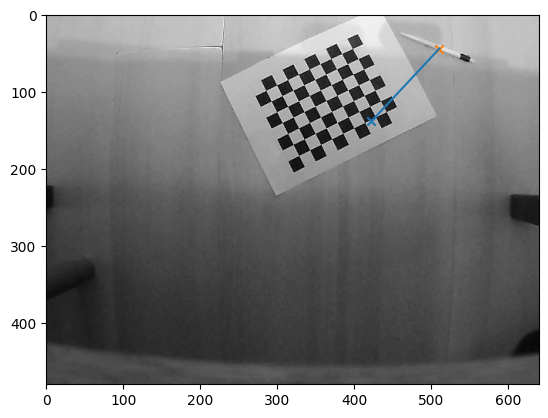

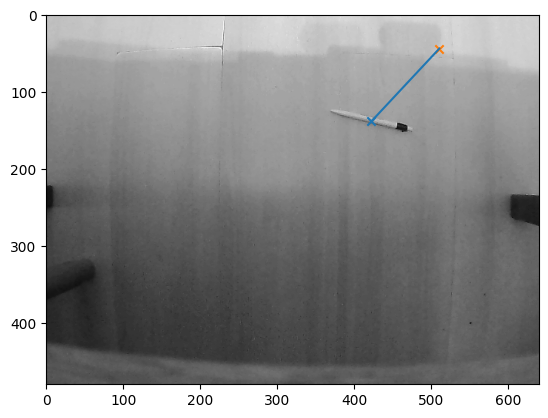

In [68]:
plt.imshow(img)
plt.scatter(centroid1[1],centroid1[0],marker="x")
plt.scatter(centroid2[1],centroid2[0],marker="x")
plt.plot((centroid1[1],centroid2[1]),(centroid1[0],centroid2[0]))
plt.show()
img2=io.imread("./data/object_1.png")
plt.imshow(img2)
plt.scatter(centroid1[1],centroid1[0],marker="x")
plt.scatter(centroid2[1],centroid2[0],marker="x")
plt.plot((centroid1[1],centroid2[1]),(centroid1[0],centroid2[0]))
plt.show()